# Analiza prognozy pozyczek uzywając Decision Trees, SVM i innych modeli
## Autorzy
- Damian Kijańczuk s20154
- Szymon Ciemny    s21355

## Cel zadania
Kozystając z SVM oraz Drzew Decyzyjnych, utworzyć model stanowiący o udzieleniu kredytu.

## Przygotowanie środowiska
Oprócz python3, potrzebne nam będą paczki:
- pandas
- numpy
- sklearn
- matplotlib
- seaborn

## [Dane](https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset?resource=download)

## Wczytanie i przygotowanie danych

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("dane2.csv", delimiter=",")
df = df.drop(columns=["Loan_ID"])
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


Zobaczmy więc jak wyglądają wczytane przez nas dane.

In [2]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Sprawdźmy takze czy w tabeli znajdują się komórki bez wartości.

In [3]:

df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

O NIE!!! 😱 😱 😱  W naszych danych są komórki bez wartości!

Uzupełnijmy je kozystając z wbudowanej funkcji paczki 'pandas' oraz średnich i typowych wartości.

In [4]:
columns = [
    'LoanAmount',
    'Loan_Amount_Term',
    'Credit_History'
]
for column in columns:
    df[column] = df[column].fillna(df[column].mean())

columns = [
    'Gender',
    'Married',
    'Dependents',
    'Self_Employed'
]
for column in columns:
    df[column] = df[column].fillna(df[column].mode()[0])

df.isnull().sum()


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

😎 SUPER 😎

Z tak wypełnionymi danymi spójżmy sie blizej naszmy danym.

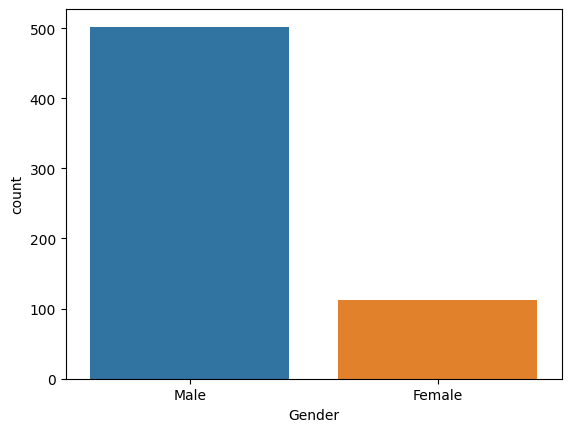

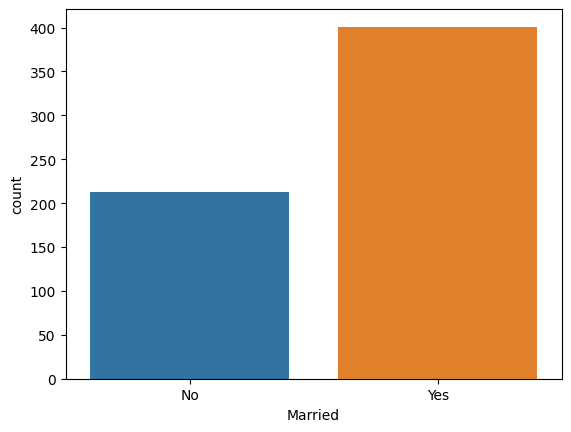

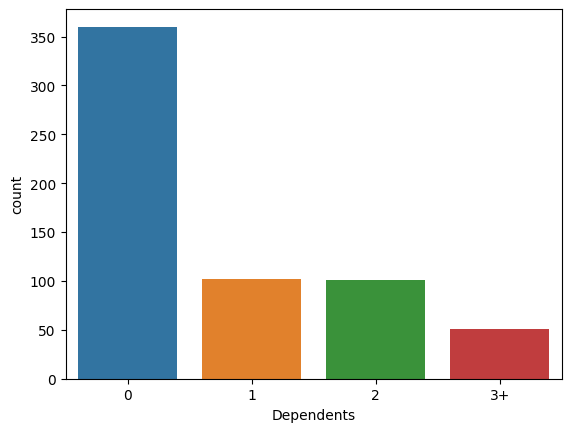

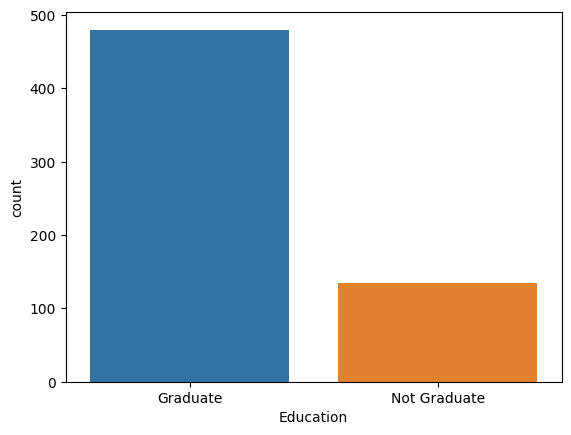

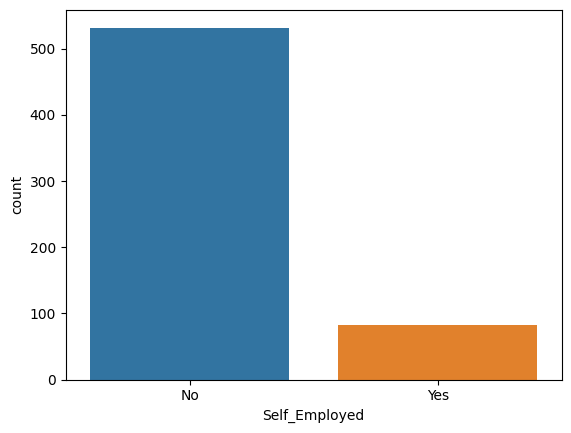

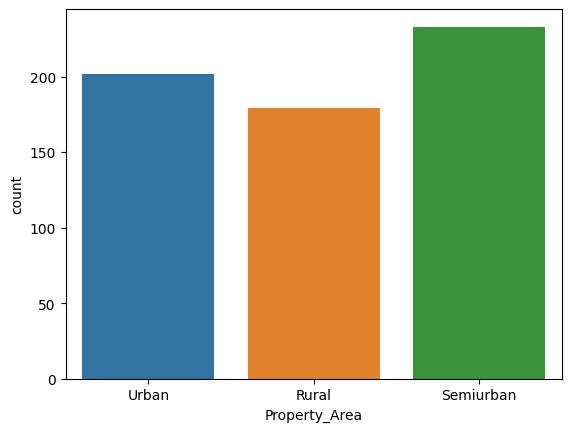

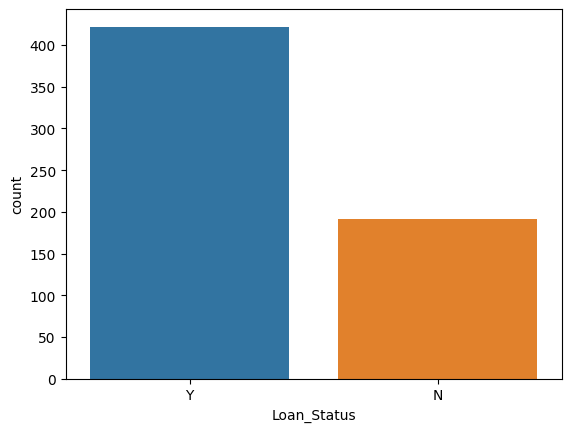

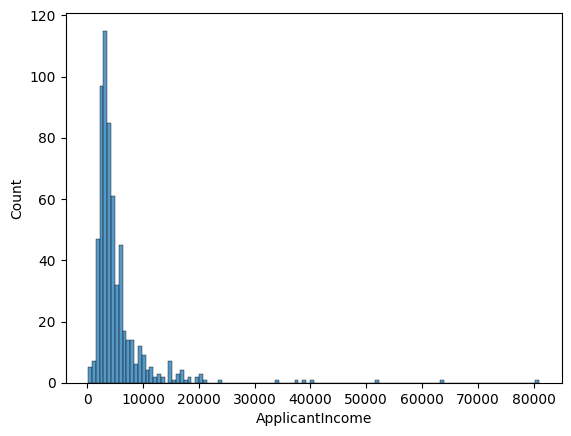

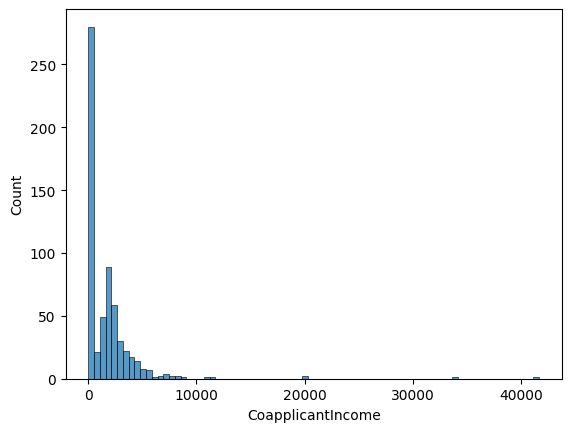

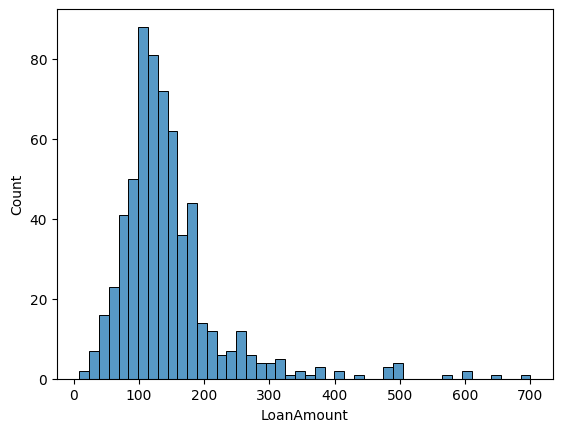

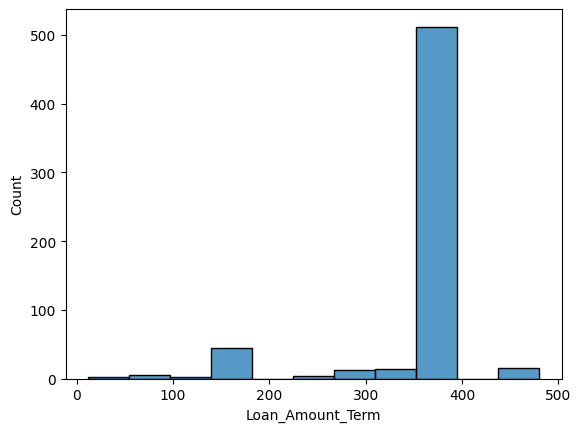

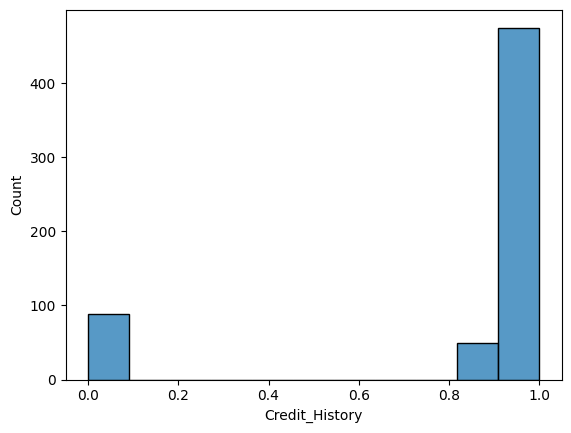

In [5]:
countColumns = [
    "Gender",
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "Property_Area",
    "Loan_Status"   
]
for column in countColumns:
    sns.countplot(x=df[column])
    plt.show()

countColumns = [
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History" 
]
for column in countColumns:
    sns.histplot(df[column])
    plt.show()


Z danych wynika ze większość kredytobiorców:
- to męzczyźni
- NIE ma dzieci
- ukończyli studia
- NIE są samozatrudnieni

Widzimy takze, ze mimo ze wiekszość zarabia podobną ilość pieniędzy część zdobywa ZNACZNIE więcej niz inni. Bedziemy musieli sobie z tym poradzić za pomocą funkcji logarytmicznej.

In [6]:
columns = [
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term"
]

for column in columns:
    # apply log transformation to the attribute
    df[column] = np.log(df[column]+1)


Przed tworzeniem modeli będziemy musieli poradzić sobie z wartościami wyrazonymi przez tekst (np. płeć). Zamienimy je na wartości liczbowe.

In [7]:
from sklearn.preprocessing import LabelEncoder
columns = [
    "Gender",
    "Married",
    "Education",
    "Self_Employed",
    "Property_Area",
    "Loan_Status",
    "Dependents"]
le = LabelEncoder()
for col in columns:
    df[col] = le.fit_transform(df[col])
df[columns]

,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status,Dependents
0,1,0,0,0,2,1,0
1,1,1,0,0,0,0,1
2,1,1,0,1,2,1,0
3,1,1,1,0,2,1,0
4,1,0,0,0,2,1,0
...,...,...,...,...,...,...,...
609,0,0,0,0,0,1,0
610,1,1,0,0,0,1,3
611,1,1,0,0,2,1,1
612,1,1,0,0,2,1,2


## Modelowanie

Z tak przygotowanymi danymi mozemy tworzyc rózne modele. Zaczniemy oczywiście od podzielenia danych.

In [8]:
X = df.drop(columns=['Loan_Status'], axis=1)
y = df['Loan_Status']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression" : LogisticRegression(),
    "Decision Trees" : DecisionTreeClassifier(),
    "Random Trees" : RandomForestClassifier(),
    "Extra Trees" : ExtraTreesClassifier(),
    "SVC" : SVC(),
    "SVC poly" : SVC(kernel='poly', degree=10, C=1)
}

for name in models:
    models[name].fit(x_train, y_train)
    print ("{:<20} | {:<15}".format(name, models[name].score(x_test, y_test)*100))


Logistic Regression  | 78.37837837837837
Decision Trees       | 65.4054054054054
Random Trees         | 78.37837837837837
Extra Trees          | 74.05405405405405
SVC                  | 64.86486486486487
SVC poly             | 77.83783783783784


Jak widać większość modeli ma dokładność na poziomie ~76%. Jedynie 'Decision Trees' oraz zwykłe 'SVC' mają niski wynik ~65%.

Zobrazujmy teraz wybrane modele na wykresach.

[Text(0.30283135981665393, 0.9722222222222222, 'X[9] <= 0.421\ngini = 0.417\nsamples = 429\nvalue = [127, 302]'),
 Text(0.15546218487394958, 0.9166666666666666, 'X[6] <= 8.996\ngini = 0.153\nsamples = 60\nvalue = [55, 5]'),
 Text(0.14323911382734913, 0.8611111111111112, 'X[5] <= 8.37\ngini = 0.126\nsamples = 59\nvalue = [55, 4]'),
 Text(0.11879297173414821, 0.8055555555555556, 'X[8] <= 5.453\ngini = 0.051\nsamples = 38\nvalue = [37, 1]'),
 Text(0.10656990068754775, 0.75, 'X[5] <= 7.842\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.09434682964094729, 0.6944444444444444, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.11879297173414821, 0.6944444444444444, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.13101604278074866, 0.75, 'gini = 0.0\nsamples = 31\nvalue = [31, 0]'),
 Text(0.16768525592055003, 0.8055555555555556, 'X[5] <= 8.521\ngini = 0.245\nsamples = 21\nvalue = [18, 3]'),
 Text(0.15546218487394958, 0.75, 'X[0] <= 0.5\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),


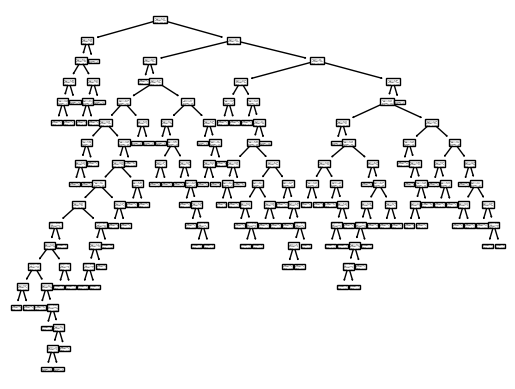

In [10]:
from sklearn import tree
tree.plot_tree(models["Decision Trees"])

Na koniec zaprezentujmy jeszcze 'correlation matrix' naszych danych.

<AxesSubplot:>

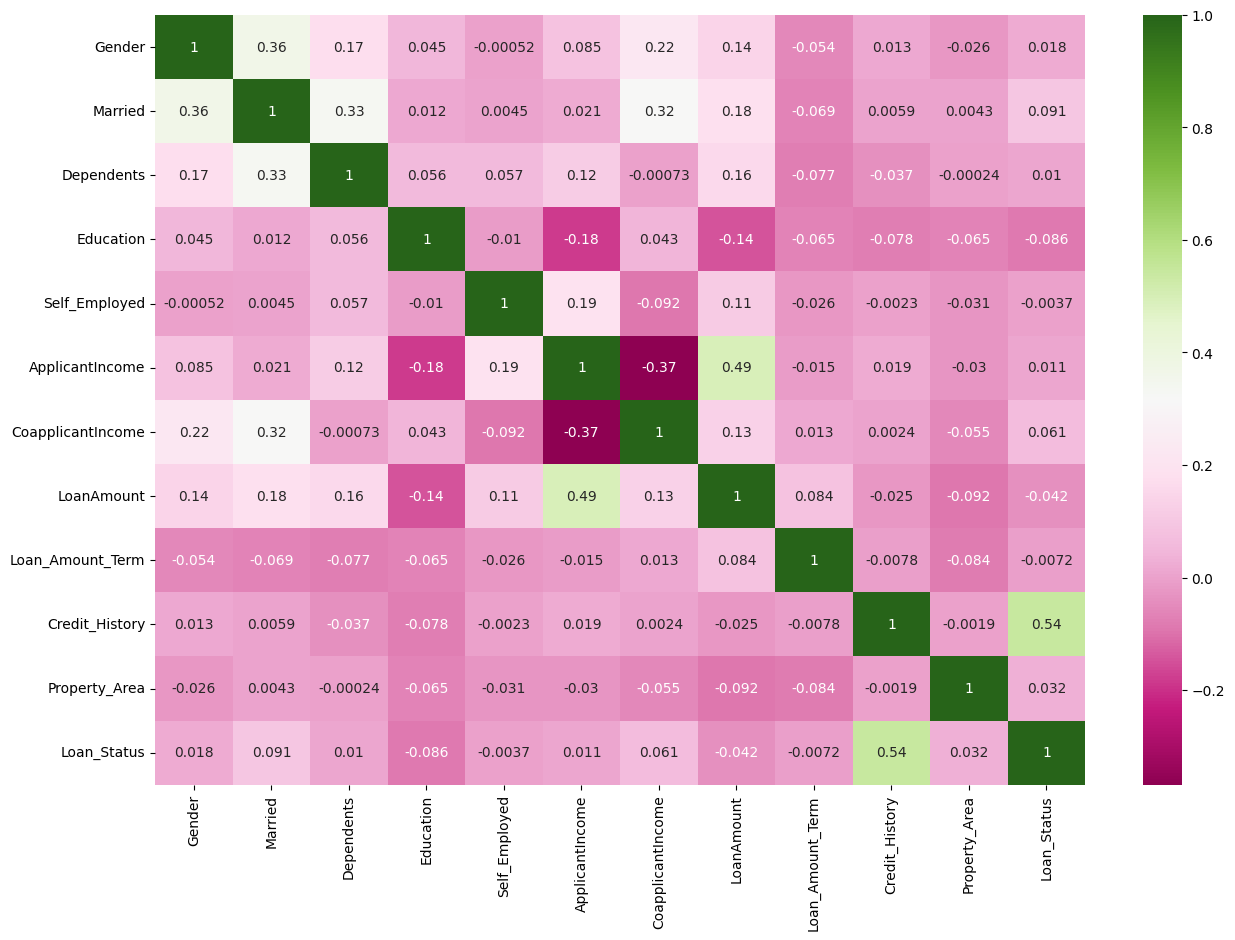

In [28]:
corr = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot = True, cmap="PiYG")

## Podsumowanie

Jak widać nawet studenci PJATK na swoim słabym komputerze mogą utworzyć modele przewidujące o dokładności nawet 78%.